<h1 align="center"> The Battle of Neighborhoods <h1/>

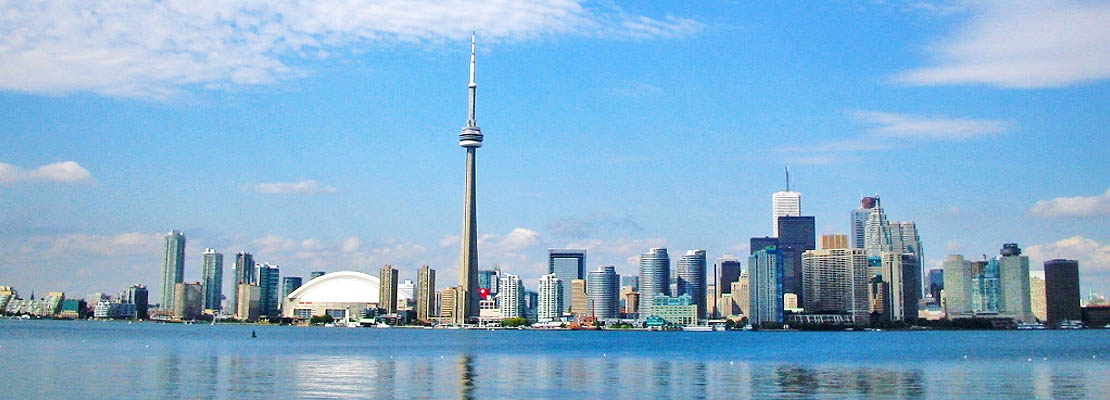

To complete this module, I will take the idea suggested by the course instructor, and will work on a project that will help small entrepreneurs to find the best location in Toronto city to open their business. 

### 1- Business problem
Toronto is the most populous city in Canada, and also the largest one. Being a centre of business, finance, arts, and culture, Toronto has become one of the most multicultural cities in the world. Not to mention that the city is the most populous and largest in Canada. 
When you have that much space available, how do you know where to open a new business? My goal with this project is to help a possible stakeholder to choose the best place to open his restaurant, considering the competition and population in each area. 


### 2- Target audience 
Business entrepreneur that wants to open a new restaurant in Toronto.
Enthusiasts in data science interested in learning about working with foursquare, folium, k-means clustering, pandas,numpy, etc.
Tourists or residents looking for an area with a lot of restaurants


### 3- The data
First, we need data about the city of Toronto, its neighborhoods and boroughs. Wikipedia have all the information available at: 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M <br>
BeautifulSoup will be used for scrapping.

<br>

Then, we will need information about restaurants in each area. Foursquare API will be used to extract the venues, addresses and ratings. Foursquare API can be found at https://developer.foursquare.com/docs/api-reference/venues/explore/

<br>

In order to explore the data visually, I will be using Folium. Folium is a python library that can create interactive maps using coordinate data.
Coordinates will be obtained via Geocode(from geopy).

<br>

If necessary, other demographic data could be used for further tests. The data is available at: https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods
